In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import os
import argparse
import copy

from models import *
depth = 256
lr = 4e-2
formatted_lr = "{:.0e}".format(lr)
use_bn = True
smooth_init = True
adaptive = False
planes = 16
seed = 0


In [82]:
# Select the non linearity: can be either 'Gelu' or 'ReLU'
non_lin = 'gelu'


In [83]:
net = iTinyResnet(
    depth,
    in_planes=planes,
    use_bn=use_bn,
    non_lin=non_lin, 
    )

In [84]:
if smooth_init:
    print("we initialize the inner weights smoothly")
    state_dict = net.state_dict()
    modules = ['conv1', 'conv2', 'bn1', 'bn2'] if use_bn else ['conv1', 'conv2']
    for i in range(1, depth):
        for n in modules:
            for m in ['weight', 'bias']:
                state_dict['residual_layers.%d.%s.%s'%(i, n, m)] = state_dict['residual_layers.0.%s.%s'%(n, m)]
    net.load_state_dict(state_dict)

we initialize the inner weights smoothly


In [85]:
# Load checkpoint.
print("==> Resuming from checkpoint..")
checkpoint_name = "./checkpoint/ckpt_lr_%s_depth_%s_seed_%s_use_bn_%s_smooth_init_%s_adaptive_%s_non_lin_%s.pth" % (formatted_lr, depth, seed, use_bn, smooth_init, adaptive, non_lin)

checkpoint = torch.load(checkpoint_name, map_location=torch.device('cpu')
)

net.load_state_dict(checkpoint["net"])

==> Resuming from checkpoint..


<All keys matched successfully>

In [86]:
max(checkpoint['log_dict']['test_acc']), max(checkpoint['log_dict']['train_acc'])

(81.28, 82.204)

In [87]:
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# not a clean way to gather all the convolution matrices

conv1_flatten = []
for i in range(depth):
    conv1_flatten.append(net.state_dict()['residual_layers.%d.conv1.weight'%i].flatten().numpy())
conv1_flatten = np.array(conv1_flatten)

conv2_flatten = []
for i in range(depth):
    conv2_flatten.append(net.state_dict()['residual_layers.%d.conv2.weight'%i].flatten().numpy())
conv2_flatten = np.array(conv2_flatten)

In [89]:
# Let's display the smoothness of the convolution at random indices across depth

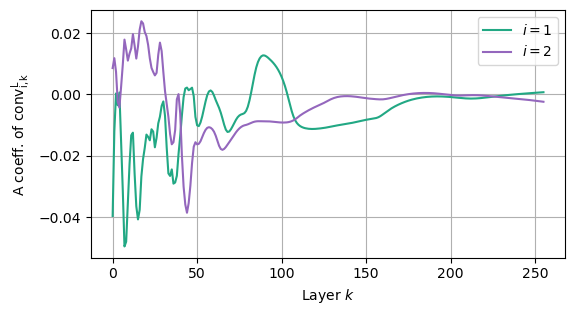

In [90]:
n_plot = 1

index = np.random.choice(conv1_flatten.shape[0], n_plot)  


a, b = 4.5, 2.5
p = 1.3
lw = .3
ms = .2

color1 = '#9467BD'  # Purple
color2 =  plt.cm.viridis(.6) #'#FFA500'  # Yellow-Orange

plt.figure(figsize=(p * a, p * b))

plt.plot(conv1_flatten[:, index], color=color2, label="$i=1$")
plt.xlabel("Layer $k$")
plt.grid(True)
plt.tight_layout()

plt.plot(conv2_flatten[:, index], color=color1, label="$i=2$")
plt.xlabel("Layer $k$")
plt.ylabel('A coeff. of $\mathrm{conv_{i,k}^L}$')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

